##Smarter Loan Risk Management for Lending Club 

**Project Summary:** Smarter Loan Risk Management with ML, Streaming & Graph Network Analytics

**Background:**
Loan default is one of the most critical challenges faced by financial institutions and peer-to-peer lending platforms like Lending Club. When borrowers fail to repay their loans, it results in direct financial losses for investors and undermines the credibility and profitability of the lending system. Meanwhile, traditional static risk models often fail to capture evolving borrower behavior or detect early warning signals, leading to preventable financial losses.

**Objective:**
To build an intelligent system that:

- Predicts post-loan default risk using MLlib models.
- Fuses real-time and historical loan data for timely decision-making.
- Analyzes borrower networks using GraphFrames to uncover hidden risk clusters.

**Scope:**

Data Sources
- Historical: Lending Club loan data (borrower info, credit history, loan terms).
- Real-Time Simulation: Streaming batches mimicking live loan performance updates.

MLlib Modeling
- Algorithms: Logistic Regression, Random Forest, Gradient Boosted Trees.
- Engineered Features: Credit score, income, utilization ratio, loan purpose, etc.
- Evaluation: AUC, precision-recall, F1 score, and confusion matrix.

Streaming-Static Data Join
- Real-time loan updates joined with static borrower profiles.
- Structured Streaming ensures up-to-date risk predictions for new activity.

Graph Analysis (GraphFrames)
- Build borrower networks based on similar credit, zip code, income.
- Run Label Propagation to detect risk communities.
- Use PageRank and Connected Components to identify influential defaulters and isolated borrowers.

**Business Value:**

- Early Risk Detection: Combines real-time and historical signals to flag high-risk loans faster than static scoring.

- Loss Reduction: Enables proactive recovery strategies by identifying clusters of risky borrowers.

- Investor Confidence: Improves portfolio performance and credit allocation, reinforcing trust and engagement.

- Operational Efficiency: Streamlines loan monitoring and recovery prioritization through automation.

**Conclusion:**
This project integrates scalable machine learning, real-time analytics, and network science to create a next-generation credit risk platform. It empowers lenders with early warning systems and deeper borrower insights, driving smarter lending and safer returns. 

#### **About Dataset**
**Context**
Lending Club is a peer-to-peer lending platform that allows borrowers to obtain loans directly from individual and institutional investors. The company, which was founded in 2007, acts as a middleman, connecting borrowers with lenders, and charging fees for its services. Loans issued through Lending Club can be used for a variety of purposes, including debt consolidation, home improvement, and small business expenses. The platform is available to borrowers and investors in the United States.

**About the dataset**
The Lending Club loan dataset (571.76MB) is a collection of information on loans issued through the Lending Club platform. The dataset includes information on the borrower, such as credit score, income, and employment history, as well as details about the loan, including the loan amount, interest rate, and loan status. The dataset also includes information on the loan's purpose and the borrower's credit history. Here are the changes applied to the dataset before analysis:

- Changed the dataset to Parquet — a fast, columnar, and efficient binary file format optimized for analytical workloads
- Parquet preserves all data type metadata (such as categorical types) and offers significantly smaller file sizes and faster read/write performance compared to CSV
- Created a data-catalog in CSV
- Changed all numerical columns to proper datatype in order to reduce memory usage and to improve the dataset usability
- All string/object columns were transformed to category pandas data type
- All data columns were changed to pandas datetime
- All numerical string columns are fixed to numerical (for example, int_rate)

####Section 1: Post-Loan Default Risk Modeling with Apache Spark MLlib

**Data Loading & Preprocessing (DataFrame API)**

In [0]:
# Load the parquet file (uploaded to a Volume)
df = spark.read.parquet("/FileStore/tables/lending_club_clean.parquet")

In [0]:

row_count = df.count()           
column_count = len(df.columns)   

print(f"row_count: {row_count}, column_count: {column_count}")


row_count: 2925492, column_count: 141


In [0]:
df.printSchema()


root
 |-- id: long (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: float (nullable = true)
 |-- term: short (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: timestamp (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: short (nullable = true)
 |-- earliest_cr_lin

**Handling Missing Values**

In [0]:
from pyspark.sql.functions import col, count, isnan, when
from pyspark.sql.types import DoubleType, FloatType

# Step 1: Get data types of each column
dtypes = dict(df.dtypes)

# Step 2: Build expressions to count missing values
# For float/double types, treat both null and NaN as missing
# For other types, only count nulls
exprs = [
    count(
        when(
            col(c).isNull() | isnan(col(c)) if dtypes[c] in ['double', 'float']
            else col(c).isNull(),
            c
        )
    ).alias(c)
    for c in df.columns
]

# Step 3: Calculate missing value counts
missing_counts = df.select(exprs)

# Step 4: Show the result in vertical format with full column names
missing_counts.show(vertical=True, truncate=False)


-RECORD 0---------------------------------------------
 id                                         | 0       
 loan_amnt                                  | 0       
 funded_amnt                                | 0       
 funded_amnt_inv                            | 0       
 term                                       | 0       
 int_rate                                   | 0       
 installment                                | 0       
 grade                                      | 0       
 sub_grade                                  | 0       
 emp_title                                  | 264086  
 emp_length                                 | 205220  
 home_ownership                             | 0       
 annual_inc                                 | 0       
 verification_status                        | 0       
 issue_d                                    | 0       
 loan_status                                | 0       
 pymnt_plan                                 | 0       
 url      

**Columns to drop (missing rate > 70.0%)**

In [0]:
total_rows = row_count

# Convert the result of missing values to a dictionary format
missing_counts_dict = missing_counts.collect()[0].asDict()

# Set the threshold for missing rate
threshold = 0.7

# Filter columns with missing rate greater than the threshold
cols_to_drop = [
    col_name for col_name, miss_count in missing_counts_dict.items()
    if miss_count / total_rows > threshold
]

# Print the columns to be dropped
print(f"Columns to drop (missing rate > {threshold * 100}%):")
print(cols_to_drop)

# Drop columns with high missing rates
df_cleaned = df.drop(*cols_to_drop)

# Print the number of columns before and after cleaning
print(f"Columns before: {column_count}, after cleaning: {len(df_cleaned.columns)}")


Columns to drop (missing rate > 70.0%):
['verification_status_joint', 'sec_app_earliest_cr_line', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status']
Columns before: 141, after cleaning: 132


In [0]:
from pyspark.sql.types import TimestampType

# Identify all columns of TimestampType
timestamp_columns = [field.name for field in df_cleaned.schema.fields if isinstance(field.dataType, TimestampType)]

# Print the columns that will be dropped
print(f"Timestamp columns to drop: {timestamp_columns}")

# Drop the timestamp columns from the DataFrame
df_cleaned = df_cleaned.drop(*timestamp_columns)

# Print the number of remaining columns
print(f"Remaining number of columns after dropping timestamps: {len(df_cleaned.columns)}")


Timestamp columns to drop: ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
Remaining number of columns after dropping timestamps: 127


In [0]:
from pyspark.sql.functions import col, count, when, lit, isnan, percentile_approx
from pyspark.sql.types import StringType, NumericType

# Get schema
schema = dict(df_cleaned.dtypes)

# Separate columns by type
categorical_cols = [c for c, t in schema.items() if t == 'string']
numeric_cols = [c for c, t in schema.items() if t in ['int', 'float']]

# Fill categorical columns with mode
for c in categorical_cols:
    non_null_df = df_cleaned.filter(col(c).isNotNull())
    if non_null_df.count() > 0:
        mode_value = non_null_df.groupBy(c).count().orderBy("count", ascending=False).first()[0]
        df_cleaned = df_cleaned.fillna({c: mode_value})

# Fill numeric columns with median
for c in numeric_cols:
    if df_cleaned.filter(col(c).isNotNull()).count() > 0:
        median_value = df_cleaned.approxQuantile(c, [0.5], 0.01)[0]
        df_cleaned = df_cleaned.fillna({c: median_value})

print("Missing values filled: mode for categorical columns, median for numeric columns.")


Missing values filled: mode for categorical columns, median for numeric columns.


**Check the loan status**

In [0]:
df_cleaned.groupBy("loan_status").count().orderBy("count", ascending=False).show()


+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1497783|
|             Current|1031016|
|         Charged Off| 362548|
|  Late (31-120 days)|  16154|
|     In Grace Period|  10028|
|   Late (16-30 days)|   2719|
|              Issued|   2062|
|Does not meet the...|   1988|
|Does not meet the...|    761|
|             Default|    433|
+--------------------+-------+



**Pipelines of Data Cleaning and Feature Engineering**

In [0]:
from pyspark.sql.functions import col, when, log1p
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Step 1: Define the Target Label: Default vs Non-Default
df_labeled = df_cleaned.withColumn(
    "loan_default",
    when(col("loan_status").isin(
        "Charged Off", "Default", "Late (31-120 days)", 
        "Does not meet the credit policy. Status: Charged Off"), 1)
    .when(col("loan_status").isin(
        "Fully Paid", "Does not meet the credit policy. Status: Fully Paid"), 0)
)


In [0]:
df_labeled.groupBy("loan_default").count().show()


+------------+-------+
|loan_default|  count|
+------------+-------+
|        null|1048574|
|           1| 379135|
|           0|1497783|
+------------+-------+



In [0]:
# Step 2: Feature engineering

# Create a new DataFrame with the necessary transformations
df_fe = df_labeled \
    .withColumn("fico_avg", (col("fico_range_low") + col("fico_range_high")) / 2) \
    .withColumn("income_log", log1p(col("annual_inc"))) \
    .withColumn(
        "utilization_ratio",
        when(
            (col("revol_util").isNotNull()) &
            (col("revol_bal").isNotNull()) &
            (col("total_rev_hi_lim").isNotNull()) &
            (col("total_rev_hi_lim") != 0),
            (col("revol_util") / 100.0) * (col("revol_bal") / col("total_rev_hi_lim"))
        ).otherwise(None)
    ) \
    .dropna(subset=["loan_default", "fico_avg", "dti", "annual_inc", "loan_amnt"])

drop_cols = [
    'id', 'url', 'title', 'zip_code',  
    'emp_title',                       
    'policy_code'                    
]
df_fe = df_fe.drop(*drop_cols)
print("Current column names:")
for col_name in df_fe.columns:
    print(col_name)


Current column names:
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_length
home_ownership
annual_inc
verification_status
loan_status
pymnt_plan
purpose
addr_state
dti
delinq_2yrs
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
mths_since_last_major_derog
application_type
annual_inc_joint
dti_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acc

In [0]:
# remove lagging index columns
cols_to_exclude = [
    'loan_status', 'recoveries', 'collection_recovery_fee',
    'debt_settlement_flag', 'hardship_flag', 'deferral_term', 'hardship_amount',
    'hardship_length', 'hardship_dpd', 'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
    'total_rec_prncp', 'total_rec_int', 'total_pymnt', 'total_pymnt_inv',
    'out_prncp', 'out_prncp_inv', 'last_pymnt_amnt'
]

df_fe = df_fe.drop(*[col for col in cols_to_exclude if col in df_fe.columns])
print("Current column names:")
for col_name in df_fe.columns:
    print(col_name)

Current column names:
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_length
home_ownership
annual_inc
verification_status
pymnt_plan
purpose
addr_state
dti
delinq_2yrs
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
total_rec_late_fee
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
mths_since_last_major_derog
application_type
annual_inc_joint
dti_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_sin

In [0]:
feature_cols = [c for c in df_fe.columns if c != 'loan_default']
df_features = df_fe.select(*feature_cols)
df_labels = df_fe.select('loan_default')


**Sort and select top 30 most important features**

In [0]:
df_features.dtypes


Out[14]: [('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'float'),
 ('term', 'smallint'),
 ('int_rate', 'float'),
 ('installment', 'float'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'float'),
 ('verification_status', 'string'),
 ('pymnt_plan', 'string'),
 ('purpose', 'string'),
 ('addr_state', 'string'),
 ('dti', 'float'),
 ('delinq_2yrs', 'smallint'),
 ('fico_range_low', 'int'),
 ('fico_range_high', 'int'),
 ('inq_last_6mths', 'smallint'),
 ('mths_since_last_delinq', 'smallint'),
 ('mths_since_last_record', 'smallint'),
 ('open_acc', 'smallint'),
 ('pub_rec', 'smallint'),
 ('revol_bal', 'bigint'),
 ('revol_util', 'float'),
 ('total_acc', 'smallint'),
 ('initial_list_status', 'string'),
 ('total_rec_late_fee', 'float'),
 ('last_fico_range_high', 'int'),
 ('last_fico_range_low', 'int'),
 ('collections_12_mths_ex_med', 'smallint'),
 ('mths_since_last_major_derog', 'smallint'),
 ('applica

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import NumericType

# Step 0: set label column
label_col = "loan_default"

# Step 1: Identify numeric columns, exclude label column
numeric_cols = [f.name for f in df_fe.schema.fields if isinstance(f.dataType, NumericType) and f.name != label_col]

# Step 2: Fill missing values in numeric columns
df_fe = df_fe.fillna(0, subset=numeric_cols)

# Step 3: Ensure all numeric columns are of 'double' type
for col in numeric_cols:
    df_fe = df_fe.withColumn(col, df_fe[col].cast("double"))

# Step 4: Identify categorical columns, exclude label column
categorical_cols = [f.name for f in df_fe.schema.fields if f.dataType.simpleString() == 'string' and f.name != label_col]

# Step 5: Create StringIndexers for categorical columns
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="skip")
    for col in categorical_cols
]

# Step 6: Assemble features (numeric columns + encoded categorical columns)
feature_cols = numeric_cols + [col + "_indexed" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Step 7: Define the RandomForest model
rf = RandomForestClassifier(labelCol=label_col, featuresCol="features", numTrees=50, maxDepth=5, maxBins=100)

# Step 8: Build and fit the pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])
model = pipeline.fit(df_fe)

# Step 9: Retrieve trained Random Forest model and feature importances
rf_model = model.stages[-1]
importances = rf_model.featureImportances.toArray()

# Step 10: Match feature names with their importance scores
feature_importance_pairs = list(zip(feature_cols, importances))

# Step 11: Sort and select top 30 features
top_features = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)[:30]

# Step 12: Print top 30 most important features
print("Top 30 important features:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")


Top 30 important features:
last_fico_range_low: 0.5242
last_fico_range_high: 0.3230
total_rec_late_fee: 0.0349
term: 0.0274
int_rate: 0.0247
grade_indexed: 0.0117
fico_range_high: 0.0056
sub_grade_indexed: 0.0054
fico_avg: 0.0048
open_rv_24m: 0.0029
funded_amnt: 0.0026
open_acc_6m: 0.0025
avg_cur_bal: 0.0024
max_bal_bc: 0.0024
fico_range_low: 0.0022
open_rv_12m: 0.0022
funded_amnt_inv: 0.0021
loan_amnt: 0.0020
all_util: 0.0016
installment: 0.0016
open_il_24m: 0.0013
acc_open_past_24mths: 0.0011
dti: 0.0010
mort_acc: 0.0010
open_act_il: 0.0009
verification_status_indexed: 0.0008
inq_last_12m: 0.0008
tot_hi_cred_lim: 0.0008
bc_open_to_buy: 0.0008
mths_since_rcnt_il: 0.0007


**Model Training and Evaluation**

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Select top features
top_features = [
    "last_fico_range_low", "last_fico_range_high", "total_rec_late_fee", "term",
    "int_rate", "fico_range_high", "fico_avg", "loan_amnt", "funded_amnt_inv",
    "dti", "installment", "acc_open_past_24mths", "max_bal_bc", "fico_range_low",
    "all_util", "mort_acc", "inq_last_12m", "inq_fi", "open_il_12m",
    "funded_amnt", "open_rv_24m", "open_acc_6m", "total_cu_tl", "open_il_24m",
    "open_act_il", "avg_cur_bal", "annual_inc", "revol_util", "income_log", "utilization_ratio"
]

# Assemble features
assembler = VectorAssembler(inputCols=top_features, outputCol="features")

# RandomForest Classifier
rf = RandomForestClassifier(labelCol="loan_default", featuresCol="features", numTrees=100, maxDepth=8, seed=42)

# Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Split data into training and testing sets (80% training, 20% testing)
train_data, test_data = df_fe.randomSplit([0.8, 0.2], seed=42)

# Train model
model = pipeline.fit(train_data)

# Evaluate on test set
predictions = model.transform(test_data)

# Evaluate the model using AUC
evaluator = BinaryClassificationEvaluator(labelCol="loan_default", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

# Output the AUC score
print(f"Test AUC: {auc:.4f}")


Test AUC: 0.9385


**Post-loan default prediction with high default probability**

In [0]:
from pyspark.sql.functions import col, log1p, when

df_unknown = df.filter(
    col("loan_status").isin("Current", "Late (16-30 days)", "In Grace Period", "Issued")
)

df_unknown_fe = df_unknown \
    .withColumn("fico_avg", (col("fico_range_low") + col("fico_range_high")) / 2) \
    .withColumn("income_log", log1p(col("annual_inc"))) \
    .withColumn(
        "utilization_ratio",
        when(
            (col("revol_util").isNotNull()) &
            (col("revol_bal").isNotNull()) &
            (col("total_rev_hi_lim").isNotNull()) &
            (col("total_rev_hi_lim") != 0),
            (col("revol_util") / 100.0) * (col("revol_bal") / col("total_rev_hi_lim"))
        ).otherwise(None)
    ) \
    .na.fill(0)

df_unknown_ready = df_unknown_fe.select("id", "loan_status", *top_features).na.fill(0)

predicted_current = model.transform(df_unknown_ready)

predicted_current.select("id", "loan_status", "loan_amnt", "prediction", "probability").show(10, truncate=False)


+---------+-----------+---------+----------+-----------------------------------------+
|id       |loan_status|loan_amnt|prediction|probability                              |
+---------+-----------+---------+----------+-----------------------------------------+
|119374887|Current    |32000    |0.0       |[0.9626451313520233,0.03735486864797665] |
|119321612|Current    |40000    |0.0       |[0.9642144424803305,0.03578555751966942] |
|120122034|Current    |16000    |0.0       |[0.9641995785377491,0.035800421462250945]|
|119246018|Current    |7000     |0.0       |[0.9760566135982306,0.023943386401769465]|
|120020939|Current    |8000     |0.0       |[0.9726952325869429,0.027304767413057093]|
|120021205|Current    |30000    |0.0       |[0.9626581556383408,0.03734184436165918] |
|120115719|Current    |16000    |0.0       |[0.9512218653844512,0.04877813461554879] |
|120115696|Current    |21600    |0.0       |[0.933407174621391,0.06659282537860908]  |
|119908858|Current    |9000     |0.0       

**Extract High-risk Default Probability list, and Save to Parquet**

In [0]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType

# Step 1: Define a UDF to extract the default probability (label 1)
get_prob_1 = udf(lambda v: float(v[1]), DoubleType())

# Step 2: Add a new column for default probability
predicted_current = predicted_current.withColumn("prob_default", get_prob_1(col("probability")))

# Step 3: Select relevant columns and sort by default probability descending
high_risk_users = predicted_current.select(
    "id", "loan_status", "loan_amnt", "prediction", "prob_default"
).orderBy(col("prob_default").desc())

# Step 4: Save as Parquet (multi-part format)
high_risk_users.write.mode("overwrite").parquet("high_risk_users_parquet")

# Optional: Save as a single Parquet file (coalesced)
high_risk_users.coalesce(1).write.mode("overwrite").parquet("high_risk_users_parquet_single")

print("High-risk user list saved successfully as Parquet.")


High-risk user list saved successfully as Parquet.


####Section 2: **Spark Streaming and Static Join** between real-time loan data and the static loan history data.

**Step 1: Load the Static Reference Data**

In [0]:
# Load the static historical loan data
static_df = spark.read.parquet("/FileStore/tables/lending_club_clean.parquet") \
    .select("id", "annual_inc", "fico_range_low", "fico_range_high", "loan_status")


**Step 2: Define the Streaming Schema and Read Real-Time Data**

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Define the schema for streaming data
stream_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("loan_amnt", IntegerType(), True),
    StructField("term", IntegerType(), True),
    StructField("int_rate", DoubleType(), True),
    StructField("annual_inc", DoubleType(), True),
    StructField("fico_range_low", IntegerType(), True),
    StructField("fico_range_high", IntegerType(), True),
    StructField("revol_bal", IntegerType(), True),
    StructField("total_rev_hi_lim", IntegerType(), True),
    StructField("revol_util", DoubleType(), True),
    StructField("loan_status", StringType(), True),
    StructField("timestamp", StringType(), True)
])

# Read streaming data from the JSON source
streaming_df = spark.readStream \
    .schema(stream_schema) \
    .option("maxFilesPerTrigger", 1) \
    .json("/tmp/realistic_loan_stream")


**Step 3: Join Streaming Data with the Static Table**

In [0]:
# Perform left join on 'id' to enrich streaming data with historical data
joined_df = streaming_df.join(static_df, on="id", how="left")


**Step 4: Output to Console**

In [0]:
query = joined_df.writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", False) \
    .start()


**Real-Time Simulation**

In [0]:
import json, random, time
from datetime import datetime
import uuid

def generate_loan_record():
    return {
        "id": str(uuid.uuid4()),
        "loan_amnt": random.choice([5000, 10000, 15000, 20000]),
        "term": random.choice([36, 60]),
        "int_rate": round(random.uniform(5.0, 25.0), 2),
        "annual_inc": round(random.uniform(20000, 150000), 2),
        "fico_range_low": random.choice([660, 680, 700, 720, 740]),
        "fico_range_high": random.choice([700, 720, 740, 760, 780]),
        "revol_bal": random.randint(1000, 20000),
        "total_rev_hi_lim": random.randint(5000, 30000),
        "revol_util": round(random.uniform(10.0, 90.0), 2),
        "loan_status": "Issued",
        "timestamp": datetime.now().isoformat()
    }

# generate a new file every 10 sec
for i in range(10):  # simulate writing for 10 times
    records = "\n".join([json.dumps(generate_loan_record()) for _ in range(50)])
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    path = f"dbfs:/tmp/realistic_loan_stream/loan_batch_{timestamp}.json"
    dbutils.fs.put(path, records, overwrite=True)
    print(f"Batch {i+1} written to: {path}")
    time.sleep(10)  


Wrote 15188 bytes.
Batch 1 written to: dbfs:/tmp/realistic_loan_stream/loan_batch_20250514182706.json
Wrote 15196 bytes.
Batch 2 written to: dbfs:/tmp/realistic_loan_stream/loan_batch_20250514182716.json
Wrote 15199 bytes.
Batch 3 written to: dbfs:/tmp/realistic_loan_stream/loan_batch_20250514182726.json
Wrote 15189 bytes.
Batch 4 written to: dbfs:/tmp/realistic_loan_stream/loan_batch_20250514182736.json
Wrote 15199 bytes.
Batch 5 written to: dbfs:/tmp/realistic_loan_stream/loan_batch_20250514182747.json
Wrote 15199 bytes.
Batch 6 written to: dbfs:/tmp/realistic_loan_stream/loan_batch_20250514182757.json
Wrote 15201 bytes.
Batch 7 written to: dbfs:/tmp/realistic_loan_stream/loan_batch_20250514182807.json
Wrote 15187 bytes.
Batch 8 written to: dbfs:/tmp/realistic_loan_stream/loan_batch_20250514182817.json
Wrote 15194 bytes.
Batch 9 written to: dbfs:/tmp/realistic_loan_stream/loan_batch_20250514182827.json
Wrote 15194 bytes.
Batch 10 written to: dbfs:/tmp/realistic_loan_stream/loan_batch

#### Section 3: PySpark GraphFrames 
##### Building a borrower network based on geographic and credit behavior similarity

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs
from graphframes import GraphFrame

# Step 1: Create Spark Session
spark = SparkSession.builder \
    .appName("LoanGraphNetwork") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
    .getOrCreate()

# Step 2: Load static loan data
static_df = spark.read.parquet("/FileStore/tables/lending_club_clean.parquet")
sampled_df = static_df.sample(fraction=0.001, seed=42).limit(1000)  # Keep small subset

# Step 3: Filter necessary columns
filtered_df = sampled_df.filter(
    col("zip_code").isNotNull() &
    col("fico_range_low").isNotNull() &
    col("annual_inc").isNotNull()
).select("id", "loan_status", "annual_inc", "fico_range_low", "zip_code")


**Create vertices**

In [0]:
# Step 3: Create vertices (unique borrowers)
vertices = filtered_df.select(
    col("id").alias("id"),
    "loan_status",
    "annual_inc",
    "fico_range_low"
).dropDuplicates(["id"])

**Create edges**

In [0]:
# Step 4: Create edges (borrower pairs with similar attributes)
edges = filtered_df.alias("a") \
    .join(filtered_df.alias("b"),
          (col("a.zip_code") == col("b.zip_code")) &
          (abs(col("a.fico_range_low") - col("b.fico_range_low")) <= 20) &
          (abs(col("a.annual_inc") - col("b.annual_inc")) <= 10000) &
          (col("a.id") != col("b.id"))
         ) \
    .select(col("a.id").alias("src"), col("b.id").alias("dst")) \
    .dropDuplicates()


**Build GraphFrame**

In [0]:
# Step 5: Build GraphFrame
g = GraphFrame(vertices, edges)

/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [0]:
# Set checkpoint directory
spark.sparkContext.setCheckpointDir("dbfs:/tmp/graphframes-checkpoints")

# Step 6: Run Graph Algorithms (e.g., connected components)
components = g.connectedComponents()
components.select("id", "component").show(10, truncate=False)


/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+------+---------+
|id    |component|
+------+---------+
|449379|449379   |
|465244|465244   |
|437923|437923   |
|497836|497836   |
|359200|359200   |
|526741|526741   |
|445808|445808   |
|447035|447035   |
|442128|442128   |
|455671|455671   |
+------+---------+
only showing top 10 rows



**This means that each borrower is an isolated node, with no edges connecting them to any other borrowers in the graph.**

In [0]:
# Step 7: Run PageRank
pagerank_results = g.pageRank(resetProbability=0.15, maxIter=5)
pagerank_results.vertices.select("id", "pagerank").show(10, truncate=False)

+---------+------------------+
|id       |pagerank          |
+---------+------------------+
|1102242  |0.4936646371564919|
|126693343|0.4936646371564919|
|3065170  |0.4936646371564919|
|118245363|0.4936646371564919|
|3299929  |0.4936646371564919|
|131102710|0.4936646371564919|
|128355720|0.4936646371564919|
|135802766|0.4936646371564919|
|4765242  |3.2910975810432794|
|7103807  |0.4936646371564919|
+---------+------------------+
only showing top 10 rows



**Detect Communities with Label Propagation**

<command-2464122264107157>:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


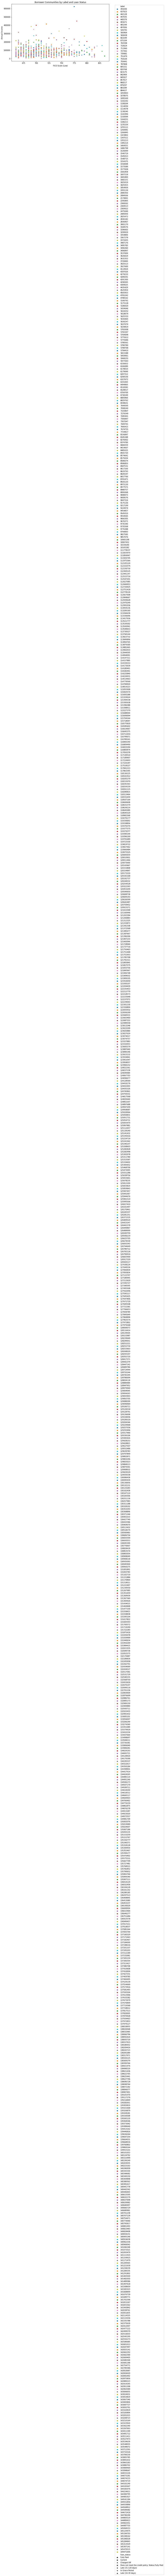

In [0]:
from graphframes import GraphFrame
from pyspark.sql.functions import col, abs
import matplotlib.pyplot as plt
import pandas as pd

# Set checkpoint directory (required by GraphFrames algorithms)
spark.sparkContext.setCheckpointDir("dbfs:/tmp/graphframes-checkpoints")

# Run label propagation
communities = g.labelPropagation(maxIter=5)
communities_df = communities.select("id", "label")

# Step 8: Join communities back with loan info
final_df = communities_df.join(vertices, on="id")

# Step 9: Convert to Pandas for small-scale visualization
pdf = final_df.select("annual_inc", "fico_range_low", "label", "loan_status").toPandas()

# Step 10: Plot with color-coded communities
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pdf,
    x="fico_range_low",
    y="annual_inc",
    hue="label",
    style="loan_status",
    palette="tab10"
)
plt.title("Borrower Communities by Label and Loan Status")
plt.xlabel("FICO Score (Low)")
plt.ylabel("Annual Income")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Visualize a small Sample (200 records) by Community detection**

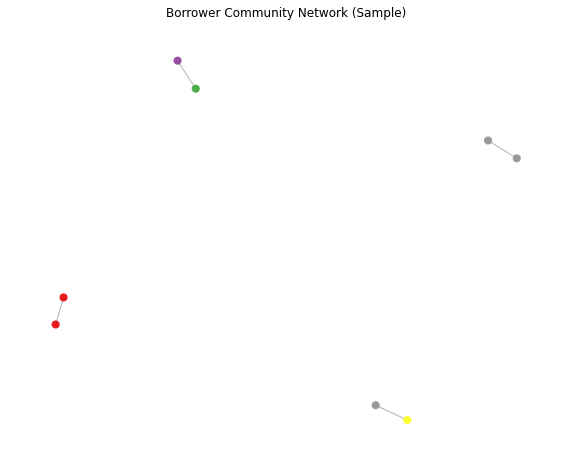

In [0]:
sample_edges = edges.limit(200).toPandas()
sample_vertices = communities.limit(200).toPandas()

# Merge labels onto edges for coloring
merged = sample_edges.merge(sample_vertices[['id', 'label']], left_on='src', right_on='id')
merged = merged.rename(columns={"label": "src_label"}).drop(columns=["id"])
merged = merged.merge(sample_vertices[['id', 'label']], left_on='dst', right_on='id')
merged = merged.rename(columns={"label": "dst_label"}).drop(columns=["id"])

# Basic network plot using matplotlib
import networkx as nx

G = nx.from_pandas_edgelist(merged, 'src', 'dst')

pos = nx.spring_layout(G, seed=42)
labels = sample_vertices.set_index("id")["label"].to_dict()

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.Set1,
                       node_color=[labels.get(node, 0) for node in G.nodes()])
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Borrower Community Network (Sample)")
plt.axis("off")
plt.show()


**Enrich Edges with Similarity Scores (e.g., income difference, FICO gap)**

In [0]:
from pyspark.sql.functions import expr

# Add a simple similarity score: lower = more similar
scored_edges = filtered_df.alias("a") \
    .join(filtered_df.alias("b"),
        (col("a.zip_code") == col("b.zip_code")) &
        (col("a.id") != col("b.id"))
    ) \
    .select(
        col("a.id").alias("src"),
        col("b.id").alias("dst"),
        abs(col("a.annual_inc") - col("b.annual_inc")).alias("inc_diff"),
        abs(col("a.fico_range_low") - col("b.fico_range_low")).alias("fico_diff")
    ) \
    .withColumn("similarity_score", expr("100 - (inc_diff / 1000 + fico_diff)"))  # Custom formula

# filter only strong similarity
weighted_edges = scored_edges.filter(col("similarity_score") > 80)


**Filter Risky Communities**

In [0]:
# Step 1: Join, and rename loan_status to avoid ambiguity
community_info = communities.join(
    static_df.select("id", col("loan_status").alias("loan_status_static")),
    on="id"
)

# Step 2: Group by community label and loan status
risk_stats = community_info.groupBy("label", "loan_status_static") \
    .count() \
    .orderBy("label", "count", ascending=False)

risk_stats.show()


+---------+------------------+-----+
|    label|loan_status_static|count|
+---------+------------------+-----+
|149471606|           Current|    1|
|145470515|           Current|    1|
|145367141|           Current|    1|
|145313529|           Current|    1|
|145284843|        Fully Paid|    1|
|145280028|        Fully Paid|    1|
|145198162|           Current|    1|
|145194703|        Fully Paid|    1|
|145129475|           Current|    1|
|145068153|           Current|    1|
|144987755|Late (31-120 days)|    1|
|144963351|           Current|    1|
|144889423|        Fully Paid|    1|
|144883519|           Current|    1|
|144746246|       Charged Off|    1|
|144672418|           Current|    1|
|144589082|           Current|    1|
|144568812|           Current|    1|
|144559896|       Charged Off|    1|
|144551856|           Current|    1|
+---------+------------------+-----+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import col

community_info = communities.join(
    static_df.select("id", col("loan_status").alias("loan_status_static")),
    on="id"
)

# Analyze risky communities
risk_stats = community_info.groupBy("label", "loan_status_static") \
    .count() \
    .orderBy("label", "count", ascending=False)

risk_stats.show(truncate=False)


+---------+------------------+-----+
|label    |loan_status_static|count|
+---------+------------------+-----+
|149471606|Current           |1    |
|145470515|Current           |1    |
|145367141|Current           |1    |
|145313529|Current           |1    |
|145284843|Fully Paid        |1    |
|145280028|Fully Paid        |1    |
|145198162|Current           |1    |
|145194703|Fully Paid        |1    |
|145129475|Current           |1    |
|145068153|Current           |1    |
|144987755|Late (31-120 days)|1    |
|144963351|Current           |1    |
|144889423|Fully Paid        |1    |
|144883519|Current           |1    |
|144746246|Charged Off       |1    |
|144672418|Current           |1    |
|144589082|Current           |1    |
|144568812|Current           |1    |
|144559896|Charged Off       |1    |
|144551856|Current           |1    |
+---------+------------------+-----+
only showing top 20 rows



**Identify and analyze risky borrower communities based on "Charged Off" loan status**

In [0]:
from pyspark.sql.functions import col

# Step 1: Identify labels (communities) that include "Charged Off" loans
risky_labels = community_info.filter(col("loan_status_static").contains("Charged")) \
    .select("label") \
    .distinct()

# Step 2: Filter all borrowers that belong to these risky communities
risky_borrowers = community_info.join(risky_labels, on="label") \
    .select("id", "label", "loan_status_static")

# Step 3: Display sample results
risky_borrowers.show(10, truncate=False)


+---------+---------+------------------+
|id       |label    |loan_status_static|
+---------+---------+------------------+
|139056040|125050831|Charged Off       |
|122663460|122663460|Charged Off       |
|125020064|125020064|Fully Paid        |
|3496897  |3496897  |Charged Off       |
|123074017|123074017|Charged Off       |
|115395638|115395638|Charged Off       |
|143342941|125050831|Current           |
|139343120|139343120|Charged Off       |
|134590715|125020064|Charged Off       |
|125551288|125551288|Charged Off       |
+---------+---------+------------------+
only showing top 10 rows



#### Conclusion:

By combining machine learning, streaming analytics, and graph-based community detection, this project delivers a powerful and scalable framework for post-loan risk management. It enables lenders to proactively detect emerging risks, understand borrower dynamics at a deeper level, and make more informed, data-driven decisions—ultimately reducing losses and improving portfolio health.

This unified platform lays the groundwork for the future of intelligent lending—where risk is not just predicted, but strategically managed in real time.